# Calculating Chicago Road Length 

Here we will be using data from OpenStreetMap to calculate the total length of major roads in every Chicago Community Area

## Importing the Necessary Packages

In [14]:
library(sf)
library(rgdal)
library(rgeos)
library(dplyr)

## Importing the OpenStreetMap Roads Data

The OpenStreetMap data for the City of Chicago is available to download as a shapefile [here](https://download.bbbike.org/osm/bbbike/Chicago/). After unzipping the download, the files labelled "Roads" should be easy to locate. Create a new folder (herein named "roads") from these files and move that folder into your working directory. Once that is accomplished, we must read in the shapefile into R. In this instance, we will use the "sf" package because its function to sum up line lengths will be needed for our processing of the data.


In [2]:
Roads <- st_read("roads")

Reading layer `roads' from data source `/Users/isaackamber/Desktop/AoT/Road Lengths/roads' using driver `ESRI Shapefile'
Simple feature collection with 156134 features and 7 fields
geometry type:  LINESTRING
dimension:      XY
bbox:           xmin: -88.01 ymin: 41.64 xmax: -87.4047 ymax: 42.09
epsg (SRID):    4326
proj4string:    +proj=longlat +datum=WGS84 +no_defs


## Importing the Chicago Map with Community Area Boundaries
The Chicago Open Data Portal provides a map of the current boundaries for each of the 77 Community Areas in city. This map can be downloaded [here](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6/data) as a Shapefile (Chi_Boundaries) which we will subsequently import.

In [3]:
Chi.Map <- st_read("Chi_Boundaries")

Reading layer `Chi_Boundaries' from data source `/Users/isaackamber/Desktop/AoT/Road Lengths/Chi_Boundaries' using driver `ESRI Shapefile'
Simple feature collection with 77 features and 9 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -87.94011 ymin: 41.64454 xmax: -87.52414 ymax: 42.02304
epsg (SRID):    4326
proj4string:    +proj=longlat +ellps=WGS84 +no_defs


## Reprojecting our Data

As we can see from the "proj4string" row of the above output, the CRS of the two sf dataframes are not identical. We must now reproject them to remedy this. We will use the planar UTM CRS for now because subsequent functions assume that our spatial data is planar. Chicago lies in zone 16 of the UTM CRS, corresponding to CRS number 26916.

In [4]:
Chi.Map <- st_transform(Chi.Map, 26916) #Reproject to UTM zone 16
Roads <- st_transform(Roads, 26916) #Reproject to UTM zone 16
st_crs(Roads) == st_crs(Chi.Map) #Check to make sure of equivalent CRS before continuing

[1] TRUE

## Limit Roads to Chicago Boundaries
The original shapefile contained a rectangular selection far beyond the official city limits of Chicago. Using our Chicago map, we must create a new roads variable consisting only of the roads that fall inside of the Chicago city boundaries.

In [5]:
#Subset for roads only within boundaries of Chicago 
Chi.Roads <- Roads[Chi.Map,]

## Selecting Road Types
OpenStreetMap provides "Roads" data including everything from footpaths and bikepaths to highways and other major roads. For the purposes of proxying traffic emissions, the main roads will clearly be more useful than roads with little to no vehicle traffic. Therefore, we must select certain road types that we will classify as "main" roads.

In [6]:
#Examine the road types included in the data
summary(Chi.Roads$type)

#Select the type of roads that we will use for our finally road length calculations (Change as needed)
main <- c("primary", "secondary", "tertiary", "service", "motorway")

#Filter the roads data to only include the main types
Main.Roads <- Chi.Roads %>%
  filter(type %in% main)


abandoned      bridleway   construction       crossing       cycleway 
             1              0             12              0            231 
      elevator        footway  living_street       motorway  motorway_link 
             8           7279              3            535            686 
          path     pedestrian        primary   primary_link       proposed 
          1797            291           4362             80             41 
   residential      secondary secondary_link        service       services 
         10621           5386             65          34407              0 
         steps       tertiary  tertiary_link          track          trunk 
           595           1508             21            275            206 
    trunk_link   unclassified 
           147            313

Warning message:
“package ‘bindrcpp’ was built under R version 3.4.4”

## Find Intersections between Roads and Community Areas
We now need to find which roads lie inside of which Community Areas and break the roads up into segments that lie solely inside of one Community Area

In [7]:
#Get intersection of Roads and CAs
ints <- st_intersection(Main.Roads, Chi.Map)

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”

## Calculate Road Length in Each Community Area
Next, we will use the new segments to calculate the total length of roads (in meters) inside of each Community Area. Then, convert this to kilometers.

In [8]:
#Examine both int and Chi.Map to find name of variable working as an index for the Community Area
glimpse(ints)
glimpse(Chi.Map)

Observations: 48,001
Variables: 17
$ osm_id     <dbl> 23477127, 24067910, 24071174, 24081882, 24085598, 240949...
$ name       <fct> East 31st Street, NA, South Doctor Martin Luther King Ju...
$ ref        <fct> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, ...
$ type       <fct> secondary, service, secondary, tertiary, secondary, seco...
$ oneway     <int> 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,...
$ bridge     <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ maxspeed   <int> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, ...
$ perimeter  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ community  <fct> DOUGLAS, DOUGLAS, DOUGLAS, DOUGLAS, DOUGLAS, DOUGLAS, DO...
$ shape_len  <dbl> 31027.05, 31027.05, 31027.05, 31027.05, 31027.05, 31027....
$ shape_area <dbl> 46004621, 46004621, 46004621, 46004621, 46004621, 460046...
$ area       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ comarea    <dbl

We see a variable "area_numbe" that corresponds to one of the 77 Community Areas (area_num_1 is identical)

In [9]:
#Calculate the total length of the segmented roads inside of each Community Area
CA.Roads <- tapply(st_length(ints), ints$area_numbe, sum)

#Convert length in meters to kilometers
CA.Roads <- CA.Roads / 1000

## Match the Road Length Indices to the Named Community Areas 

Right now, we have a numerical vector of road lengths by Community Area. We need to first create an empty column in the Chicago Community Area dataframe and then fill that column up with the road lengths in the corresponding Community Area.

In [10]:
#Create column of 0s in Chi.Map  for road lengths 
Chi.Map$road_length <- rep(0, nrow(Chi.Map))

#Match index to assign each CA with the corresponding road length
Chi.Map$road_length[match(names(CA.Roads), Chi.Map$area_numbe)] = CA.Roads

## Viewing our Data
Now that we have calculated the total road length in each Community Area, let's plot it to ensure that it makes sense and to visualize it. 

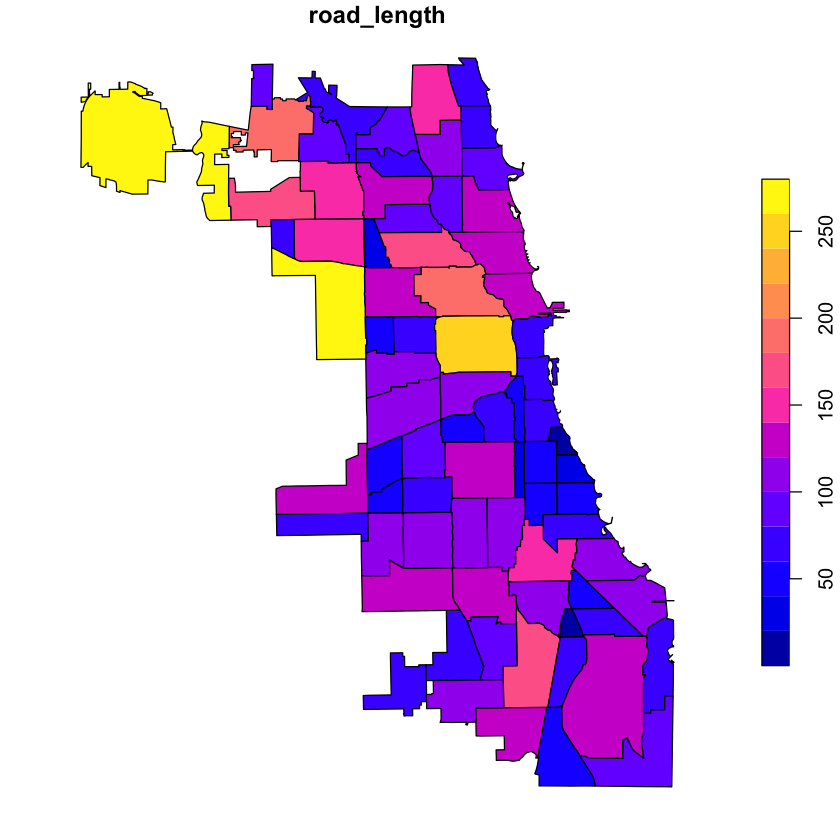

In [11]:
plot(Chi.Map[,"road_length"])